In [123]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import cycle
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [124]:
AAPL = pd.read_csv(r"C:\Users\bolaj\Desktop\Stock Price Prediction\Stock Market Price  Prediction\Methodology\AAPL_daily_data.csv")
TSLA = pd.read_csv('C:/Users/bolaj/Desktop/Stock Price Prediction/Stock Market Price  Prediction/Methodology/TSLA_daily_data.csv')
GOOG = pd.read_csv('C:/Users/bolaj/Desktop/Stock Price Prediction/Stock Market Price  Prediction/Methodology/GOOGL_daily_data.csv')
MSFT = pd.read_csv('C:/Users/bolaj/Desktop/Stock Price Prediction/Stock Market Price  Prediction/Methodology/MSFT_daily_data.csv')
AMZN = pd.read_csv('C:/Users/bolaj/Desktop/Stock Price Prediction/Stock Market Price  Prediction/Methodology/AMZN_daily_data.csv')

In [125]:
def Test_Stationarity(timeseries):
  result = adfuller(timeseries['Adj Close'], autolag = 'AIC')
  print("Results of Dickey Fuller Test")
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Number of lags used: {result[2]}')
  print(f'Number of observations used: {result[3]}')
  for key, value in result[4].items():
    print(f'critical value ({key}): {value}')

In [126]:
# Define a function to save the plots using the title as the filename
def save_plot_with_title(folder_name):
    # Create the directory if it doesn't exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Get the current figure title
    title = plt.gca().get_title()  # Get the title of the current axes
    if not title:  # If no title, use a default name
        title = "plot"
    
    # Sanitize the title to create a valid filename
    sanitized_title = "".join(c for c in title if c.isalnum() or c in (' ', '_')).rstrip()
    file_name = f"{sanitized_title}.png"  # Set the file name

    # Save the current figure
    plt.savefig(os.path.join(folder_name, file_name))
    plt.close()

In [127]:
folder = 'Microsoft_visuals'

## MICROSOFT

### Preamble

In [128]:
MSFT.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,37.349998,37.400002,37.099998,37.160000,31.120731,30632200
1,2014-01-03,37.200001,37.220001,36.599998,36.910000,30.911362,31134800
2,2014-01-06,36.849998,36.889999,36.110001,36.130001,30.258141,43603700
3,2014-01-07,36.330002,36.490002,36.209999,36.410000,30.492617,35802800
4,2014-01-08,36.000000,36.139999,35.580002,35.759998,29.948256,59971700


In [129]:
MSFT.shape

(2684, 7)

In [130]:
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2684 entries, 0 to 2683
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2684 non-null   object 
 1   Open       2684 non-null   float64
 2   High       2684 non-null   float64
 3   Low        2684 non-null   float64
 4   Close      2684 non-null   float64
 5   Adj Close  2684 non-null   float64
 6   Volume     2684 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 146.9+ KB


In [131]:
MSFT.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [132]:
# Change Dtype of Date column
MSFT["Date"] = pd.to_datetime(MSFT["Date"])

In [133]:
max_date = MSFT["Date"].max()
max_date

Timestamp('2024-08-30 00:00:00')

In [134]:
min_date = MSFT["Date"].min()
min_date


Timestamp('2014-01-02 00:00:00')

In [135]:
MSFT.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,37.349998,37.400002,37.099998,37.160000,31.120731,30632200
1,2014-01-03,37.200001,37.220001,36.599998,36.910000,30.911362,31134800
2,2014-01-06,36.849998,36.889999,36.110001,36.130001,30.258141,43603700
3,2014-01-07,36.330002,36.490002,36.209999,36.410000,30.492617,35802800
4,2014-01-08,36.000000,36.139999,35.580002,35.759998,29.948256,59971700


In [136]:
Test_Stationarity(MSFT)

Results of Dickey Fuller Test
Test Statistics: 1.1365389082338924
p-value: 0.9955167139218458
Number of lags used: 26
Number of observations used: 2657
critical value (1%): -3.432813541175453
critical value (5%): -2.8626284076771564
critical value (10%): -2.5673493967660432


In [137]:
# Function to detect outliers using IQR (Interquartile Range)
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Return a boolean series where True indicates an outlier
    return (df[column] < lower_bound) | (df[column] > upper_bound)

In [138]:
# Detect outliers for each numeric column (Open, High, Low, Close, Adj Close, Volume)
for column in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
    outliers = detect_outliers_iqr(MSFT, column)
    num_outliers = outliers.sum()
    print(f"Number of outliers in {column}: {num_outliers}")

Number of outliers in Open: 0
Number of outliers in High: 0
Number of outliers in Low: 0
Number of outliers in Close: 0
Number of outliers in Adj Close: 0
Number of outliers in Volume: 151


In [139]:
# Visualize the Volume column separately
plt.figure(figsize=(5, 6))
sns.boxplot(data=MSFT['Volume'])
plt.title('MSFT: Boxplot for Volume Column')
plt.ylabel('Volume')

save_plot_with_title(folder)

plt.show()

In [140]:
# Get the rows where Volume is an outlier
MSFTvolume_outliers = MSFT[detect_outliers_iqr(MSFT, 'Volume')]

# Display the outliers
MSFTvolume_outliers


,Date,Open,High,Low,Close,Adj Close,Volume
4,2014-01-08,36.000000,36.139999,35.580002,35.759998,29.948256,59971700
15,2014-01-24,37.450001,37.549999,36.529999,36.810001,30.827633,76395500
18,2014-01-29,35.980000,36.880001,35.900002,36.660000,30.701996,52745900
20,2014-01-31,36.950001,37.889999,36.560001,37.840000,31.690220,93162300
21,2014-02-03,37.740002,37.990002,36.430000,36.480000,30.551254,64063100
...,...,...,...,...,...,...,...
2400,2023-07-18,345.829987,366.779999,342.170013,359.489990,356.057861,64872700
2403,2023-07-21,349.149994,350.299988,339.829987,343.769989,340.487976,69368900
2406,2023-07-26,341.440002,344.670013,333.109985,337.769989,334.545258,58383700
2470,2023-10-25,345.019989,346.200012,337.619995,340.670013,338.131989,55053800


In [141]:
# Create a scatter plot for Volume highlighting outliers
plt.figure(figsize=(12, 6))
sns.scatterplot(data=MSFT, x='Date', y='Volume', hue=detect_outliers_iqr(MSFT, 'Volume'), palette={False: 'blue', True: 'red'})
plt.title('MSFT: Volume with Outliers Highlighted in Red')
plt.xticks(rotation=45)

save_plot_with_title(folder)

plt.show()


In [142]:
# Summary statistics for outliers and non-outliers
print("Non-outlier Volume statistics:")
print(MSFT[~detect_outliers_iqr(MSFT, 'Volume')]['Volume'].describe())

print("\nOutlier Volume statistics:")
print(MSFT[detect_outliers_iqr(MSFT, 'Volume')]['Volume'].describe())


Non-outlier Volume statistics:
count    2.533000e+03
mean     2.716853e+07
std      8.533553e+06
min      7.425600e+06
25%      2.089700e+07
50%      2.586140e+07
75%      3.233320e+07
max      5.250110e+07
Name: Volume, dtype: float64

Outlier Volume statistics:
count    1.510000e+02
mean     6.981623e+07
std      2.075179e+07
min      5.258870e+07
25%      5.691705e+07
50%      6.390430e+07
75%      7.513910e+07
max      2.025224e+08
Name: Volume, dtype: float64


Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

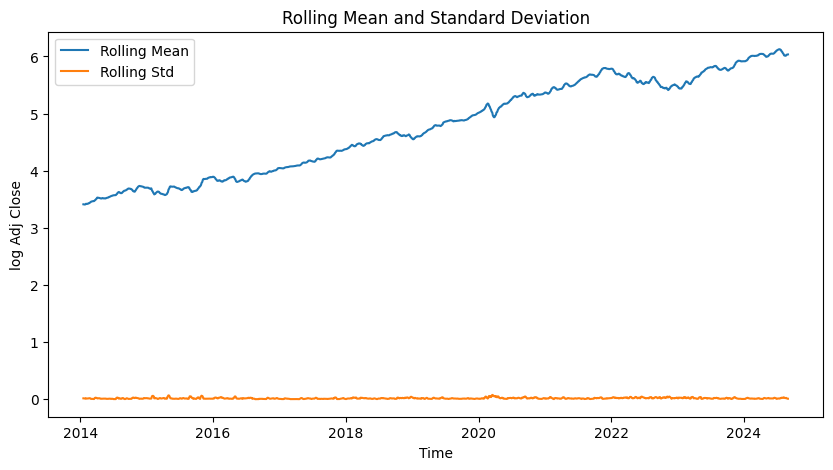

In [143]:
MSFT['log Adj Close'] = np.log(MSFT['Adj Close'])
MSFT_log_moving_avg = MSFT['log Adj Close'].rolling(12).mean()
MSFT_log_std = MSFT['log Adj Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(MSFT['Date'], MSFT_log_moving_avg, label = "Rolling Mean")
plt.plot(MSFT['Date'], MSFT_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Adj Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

### Split the data into training and test set
Training Period: 2014-01-01 - 2023-09-30

Testing Period:  2023-10-01 - 2024-04-01

In [144]:
MSFT.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'log Adj Close'],
      dtype='object')

In [145]:
Base_MSFT = MSFT.set_index('Date')

In [146]:
Base_MSFT.head()

,Open,High,Low,Close,Adj Close,Volume,log Adj Close
Date,,,,,,,
2014-01-02,37.349998,37.400002,37.099998,37.160000,31.120731,30632200,3.437874
2014-01-03,37.200001,37.220001,36.599998,36.910000,30.911362,31134800,3.431124
2014-01-06,36.849998,36.889999,36.110001,36.130001,30.258141,43603700,3.409765
2014-01-07,36.330002,36.490002,36.209999,36.410000,30.492617,35802800,3.417485
2014-01-08,36.000000,36.139999,35.580002,35.759998,29.948256,59971700,3.399471


In [147]:
# Calculate the correlation matrix
basecorr_matrix = Base_MSFT.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(basecorr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('MSFT Baseline Correlation Matrix of Features and Target (Close Price)', fontsize=16)
save_plot_with_title(folder)

# Show plot
plt.show()

In [148]:
basecorr_matrix

,Open,High,Low,Close,Adj Close,Volume,log Adj Close
Open,1.000000,0.999892,0.999877,0.999739,0.999676,-0.163694,0.956644
High,0.999892,1.000000,0.999846,0.999869,0.999795,-0.159546,0.957241
Low,0.999877,0.999846,1.000000,0.999888,0.999831,-0.168759,0.956330
Close,0.999739,0.999869,0.999888,1.000000,0.999929,-0.164727,0.956847
Adj Close,0.999676,0.999795,0.999831,0.999929,1.000000,-0.165534,0.955110
Volume,-0.163694,-0.159546,-0.168759,-0.164727,-0.165534,1.000000,-0.156689
log Adj Close,0.956644,0.957241,0.956330,0.956847,0.955110,-0.156689,1.000000


In [149]:
# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = Base_MSFT.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(Base_MSFT.values, i) for i in range(len(Base_MSFT.columns))]

# Display the VIF values
vif_data

,Feature,VIF
0,Open,32186.593269
1,High,37796.560936
2,Low,38708.873213
3,Close,55053.193497
4,Adj Close,25476.407846
5,Volume,7.509784
6,log Adj Close,69.111271


In [150]:
# Define new feature set including the original and engineered features
X_base = Base_MSFT[[ 'Open', 'High', 'Low','Volume','log Adj Close']]
y_base = Base_MSFT['Close']

In [151]:
# Train-test split (80% train, 20% test)
X_trainbase, X_testbase, y_trainbase, y_testbase = train_test_split(X_base, y_base, test_size=0.2, shuffle=False)

# Initialize MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale the features and target
X_train_scaledbase = scaler_X.fit_transform(X_trainbase)
X_test_scaledbase = scaler_y.fit_transform(X_testbase)

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaledbase = scaler.fit_transform(X_trainbase)
# X_test_scaledbase = scaler.transform(X_testbase)

### Model Trainig & Prediction

In [152]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to calculate RMSE, MAE, and R²
def evaluate_model(true_values, predicted_values, model_name):
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    
    print(f'{model_name} Evaluation:')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  MAE: {mae:.4f}')
    print(f'  R²: {r2:.4f}\n')
    
    return rmse, mae, r2


#### Arima Baseline

##### AutoArima

In [153]:
# Train the AutoARIMA model
MSFT_Auto_ARIMA_Model = auto_arima(y_trainbase, seasonal=False, stepwise=True)

In [154]:
# MSFT_Auto_ARIMA_Model = auto_arima(MSFT_Train_Data['log Adj Close'], seasonal = False,
#                                    error_action = 'ignore', suppress_warnings = True)
print(MSFT_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2147
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -5182.479
Date:                Sat, 28 Sep 2024   AIC                          10370.959
Time:                        12:30:21   BIC                          10387.973
Sample:                             0   HQIC                         10377.184
                               - 2147                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1174      0.059      1.975      0.048       0.001       0.234
ar.L1         -0.1673      0.010    -17.402      0.000      -0.186      -0.148
sigma2         7.3302      0.102     71.902      0.0

In [155]:
auto_arima_fitted = MSFT_Auto_ARIMA_Model.fit(y_trainbase)

In [156]:
# Predictions
MSFT_Auto_ARIMA_Model_pred = auto_arima_fitted.predict(n_periods=len(y_testbase))

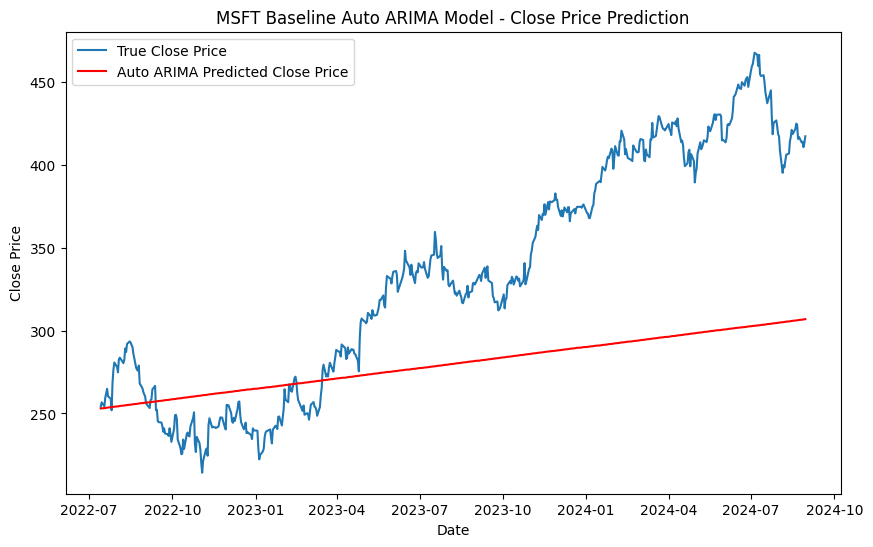

In [157]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_testbase.index, y_testbase, label='True Close Price')
plt.plot(y_testbase.index, MSFT_Auto_ARIMA_Model_pred, label='Auto ARIMA Predicted Close Price', color='red')
plt.title('MSFT Baseline Auto ARIMA Model - Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.savefig('MSFTAuto ARIMA Model - Baseline Price Prediction.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [158]:
# Evaluate Auto ARIMA model predictions
auto_arima_rmse, auto_arima_mae, auto_arima_r2 = evaluate_model(y_testbase, MSFT_Auto_ARIMA_Model_pred, "Auto ARIMA")

Auto ARIMA Evaluation:
  RMSE: 76.2736
  MAE: 61.9501
  R²: -0.1972



##### Arima

In [159]:
# ARIMA Model (let's assume p=5, d=1, q=0 as an example)
MSFT_arima_model = ARIMA(y_trainbase, order=(1, 1, 0))
MSFT_arima_fitted = MSFT_arima_model.fit()

In [160]:
# Predicting on test set
MSFT_arima_pred = MSFT_arima_fitted.predict(start=len(y_trainbase), end=len(y_trainbase)+len(y_testbase)-1, typ='levels')

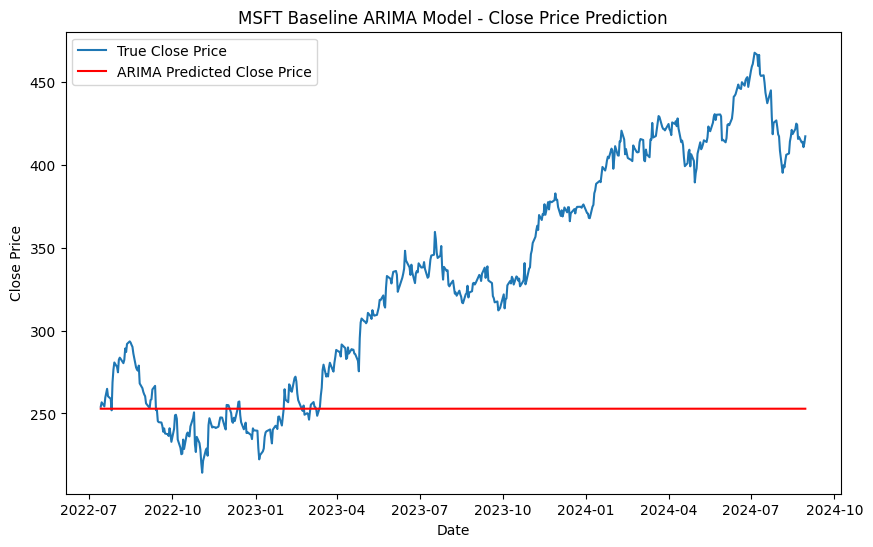

In [161]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_testbase.index, y_testbase, label='True Close Price')
plt.plot(y_testbase.index, MSFT_arima_pred, label='ARIMA Predicted Close Price', color='red')
plt.title('MSFT Baseline ARIMA Model - Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [162]:
# Evaluate ARIMA model predictions
arima_rmse, arima_mae, arima_r2 = evaluate_model(y_testbase, MSFT_arima_pred, "ARIMA")

ARIMA Evaluation:
  RMSE: 105.8875
  MAE: 84.6118
  R²: -1.3072



In [163]:
plt.figure(figsize=(10, 6))

# Actual Closing Price
plt.plot(y_testbase.index, y_testbase, color='blue', label='Actual Closing Price', linewidth=2)

# ARIMA Predicted Closing Price
plt.plot(y_testbase.index, MSFT_arima_pred, color='red', linestyle='--', label='ARIMA Predicted Price', linewidth=2)

# Auto ARIMA Predicted Closing Price
plt.plot(y_testbase.index, MSFT_Auto_ARIMA_Model_pred, color='green', linestyle='--', label='Auto ARIMA Predicted Price', linewidth=2)

plt.title('MSFT ARIMA vs Auto ARIMA Baseline: Actual vs Predicted Closing Price:', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
save_plot_with_title(folder)
plt.show()


### Feature Engineering

In [164]:
# Simple Moving Average (SMA)
MSFT['SMA_20'] = MSFT['Close'].rolling(window=20).mean()

In [165]:
# Rate of Change (RoC)
MSFT['RoC_10'] = MSFT['Close'].pct_change(periods=10) * 100  # RoC for 10 days

In [166]:
MSFT.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,log Adj Close,SMA_20,RoC_10
2679,2024-08-26,416.369995,417.279999,411.339996,413.489990,413.489990,13152800,6.024633,413.112497,1.642042
2680,2024-08-27,412.859985,414.359985,410.250000,413.839996,413.839996,13492900,6.025479,412.658496,-0.041065
2681,2024-08-28,414.880005,415.000000,407.309998,410.600006,410.600006,14882700,6.017620,412.270996,-1.501698
2682,2024-08-29,414.940002,422.049988,410.600006,413.119995,413.119995,17045200,6.023738,412.071497,-1.878727
2683,2024-08-30,415.600006,417.489990,412.130005,417.140015,417.140015,24308300,6.033422,412.503998,-0.317821


In [167]:
def compute_rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

MSFT['RSI_14'] = compute_rsi(MSFT['Close'], period=14)


In [168]:
MSFT.sample(frac=0.0045)

,Date,Open,High,Low,Close,Adj Close,Volume,log Adj Close,SMA_20,RoC_10,RSI_14
1815,2021-03-19,231.020004,232.470001,229.350006,230.350006,223.619980,46430700,5.409948,232.875001,-0.539724,42.567122
362,2015-06-11,46.660000,46.919998,46.130001,46.439999,40.503410,27347800,3.701386,47.047500,-2.128561,41.373238
249,2014-12-29,47.700001,47.779999,47.259998,47.450001,40.826534,14439500,3.709332,47.569000,1.064963,48.303934
517,2016-01-22,51.410000,52.330002,51.259998,52.290001,46.215744,37555800,3.833321,53.456000,0.230023,36.697264
1949,2021-09-29,285.100006,286.769989,283.010010,284.000000,276.868225,26353700,5.623542,297.621997,-6.830263,34.857164
2395,2023-07-11,331.059998,332.859985,327.000000,332.470001,329.295837,26698200,5.796957,336.689497,1.177722,44.550799
1880,2021-06-22,262.720001,265.790009,262.399994,265.510010,258.347992,24694100,5.554307,254.630000,5.123333,78.605098
1517,2020-01-13,161.759995,163.309998,161.259995,163.279999,156.487534,21626500,5.052976,158.130000,2.717660,67.193886
847,2017-05-15,68.139999,68.480003,67.570000,68.430000,62.517181,31530300,4.135441,68.025000,-1.411905,56.589170
2577,2024-04-01,423.950012,427.890015,422.220001,424.570007,423.043060,16316000,6.047474,417.243001,1.957157,68.125140


In [169]:
# Price Range (High - Low)
MSFT['Price_Range'] = MSFT['High'] - MSFT['Low']

In [170]:
MSFT.sample(frac=0.00045)

,Date,Open,High,Low,Close,Adj Close,Volume,log Adj Close,SMA_20,RoC_10,RSI_14,Price_Range
2574,2024-03-26,425.609985,425.98999,421.350006,421.649994,420.133575,16725600,6.040573,415.750002,1.533904,65.723468,4.639984


In [171]:
# Stock Returns
MSFT['Returns'] = MSFT['Close'].pct_change() * 100

In [172]:
# 1. Bollinger Bands
def bollinger_bands(data, window=20, num_sd=2):
    sma = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    data['Bollinger_Upper'] = sma + (rolling_std * num_sd)
    data['Bollinger_Lower'] = sma - (rolling_std * num_sd)
    return data

MSFT = bollinger_bands(MSFT)

In [173]:
# 2. Exponential Moving Averages (EMA)
MSFT['EMA_12'] = MSFT['Close'].ewm(span=12, adjust=False).mean()  # 12-day EMA
MSFT['EMA_26'] = MSFT['Close'].ewm(span=26, adjust=False).mean()  # 26-day EMA

In [174]:
# 3. MACD
MSFT['MACD'] = MSFT['EMA_12'] - MSFT['EMA_26']
MSFT['MACD_Signal'] = MSFT['MACD'].ewm(span=9, adjust=False).mean()  # Signal line (9-day EMA of MACD)

In [175]:
# Drop rows with NaN values after feature engineering
MSFT.dropna(inplace=True)

In [176]:
MSFT.head()

,Date,Open,High,Low,Close,Adj Close,Volume,log Adj Close,SMA_20,RoC_10,RSI_14,Price_Range,Returns,Bollinger_Upper,Bollinger_Lower,EMA_12,EMA_26,MACD,MACD_Signal
19,2014-01-30,36.790001,36.880001,36.230000,36.860001,30.869497,35036300,3.429769,36.2760,0.272041,59.595962,0.650002,0.545556,37.367661,35.184339,36.415784,36.497112,-0.081329,-0.176405
20,2014-01-31,36.950001,37.889999,36.560001,37.840000,31.690220,93162300,3.456008,36.3100,2.575226,62.162148,1.329998,2.658707,37.549881,35.070118,36.634894,36.596586,0.038309,-0.133462
21,2014-02-03,37.740002,37.990002,36.430000,36.480000,30.551254,64063100,3.419406,36.2885,0.274872,59.740254,1.560001,-3.594082,37.499142,35.077857,36.611064,36.587950,0.023115,-0.102147
22,2014-02-04,36.970001,37.189999,36.250000,36.349998,30.442377,54697900,3.415836,36.2995,0.497651,54.054048,0.939999,-0.356363,37.508074,35.090925,36.570900,36.570324,0.000577,-0.081602
23,2014-02-05,36.290001,36.470001,35.799999,35.820000,29.998514,55814400,3.401148,36.2700,-0.306153,42.857159,0.670002,-1.458043,37.495896,35.044103,36.455377,36.514744,-0.059367,-0.077155


In [177]:
MSFT.set_index('Date', inplace=True)

In [178]:
MSFT.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'log Adj Close',
       'SMA_20', 'RoC_10', 'RSI_14', 'Price_Range', 'Returns',
       'Bollinger_Upper', 'Bollinger_Lower', 'EMA_12', 'EMA_26', 'MACD',
       'MACD_Signal'],
      dtype='object')

In [179]:
# Calculate the correlation matrix
corr_matrix = MSFT[[ 'Close', 'Volume', 'log Adj Close',
       'SMA_20', 'RoC_10', 'RSI_14', 'Price_Range', 'Returns',
       'Bollinger_Upper', 'Bollinger_Lower', 'EMA_12', 'EMA_26', 'MACD',
       'MACD_Signal']].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('MSFT Correlation Matrix of Features and Target (Close Price) after feature Engineering', fontsize=16)
save_plot_with_title(folder)
# Show plot
plt.show()

### Arima Model Retraining

In [180]:
# Define new feature set including the original and engineered features
X = MSFT[['Volume','log Adj Close',
    'RoC_10', 'RSI_14', 'Price_Range', 'Returns', 'MACD',
       'MACD_Signal']]
y = MSFT['Close']

In [181]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,Volume,log Adj Close,RoC_10,RSI_14,Price_Range,Returns,MACD,MACD_Signal
0,0.141523,0.010428,0.507315,0.572331,0.016824,0.527857,0.503056,0.459048
1,0.439457,0.019989,0.560670,0.600104,0.044727,0.600835,0.508178,0.461154
2,0.290305,0.006652,0.507381,0.573893,0.054165,0.384894,0.507527,0.462689
3,0.242302,0.005352,0.512542,0.512353,0.028724,0.496709,0.506563,0.463697
4,0.248025,0.000000,0.493921,0.391172,0.017645,0.458662,0.503996,0.463915


In [182]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [183]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# TimeSeriesSplit for cross-validation (5 folds)
tscv = TimeSeriesSplit(n_splits=10)

In [184]:
import itertools

# Define the p, d, q ranges to search over
p = range(0, 5)
d = range(0, 2)
q = range(0, 5)
pdq = list(itertools.product(p, d, q))

# Grid search over p, d, q combinations
best_aic = np.inf
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(y_train, order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except:
        continue

print(f"Best ARIMA model: Order {best_order} with AIC {best_aic}")

Best ARIMA model: Order (3, 1, 4) with AIC 10267.6896035494


In [185]:
# Perform auto_arima with cross-validation
auto_arima_model_fe = auto_arima(y_train, 
                              exogenous=X_train,  # Using the new features
                              seasonal=False, 
                              trace=True,
                              error_action='ignore', 
                              suppress_warnings=True,
                              stepwise=True,
                              cv=tscv,
                              start_p=0, 
                              start_q=0, 
                              max_p=5, 
                              max_q=5, 
                              d=1)

# Print the best order found
print(f"Best Auto ARIMA model: {auto_arima_model_fe.order}")


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10376.579, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10317.469, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10321.096, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10377.634, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10318.708, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10318.695, Time=0.59 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10320.699, Time=0.77 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10319.718, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 4.044 seconds
Best Auto ARIMA model: (1, 1, 0)


##### Prediciton and Evaluation

In [186]:
# Fit ARIMA with best hyperparameters
arima_fitted_fe = ARIMA(y_train, order=best_order).fit()

# Predict on the test set
arima_pred_fe = arima_fitted_fe.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, typ='levels')

# Evaluate the ARIMA model
arima_rmse, arima_mae, arima_r2 = evaluate_model(y_test, arima_pred_fe, "ARIMA with Feature Engineering")

ARIMA with Feature Engineering Evaluation:
  RMSE: 101.5393
  MAE: 81.5242
  R²: -1.1250



In [187]:
# Predict with the optimized Auto ARIMA model
auto_arima_pred_fe = auto_arima_model_fe.predict(n_periods=len(y_test), exogenous=X_test)

# Evaluate the Auto ARIMA model
auto_arima_rmse, auto_arima_mae, auto_arima_r2 = evaluate_model(y_test, auto_arima_pred_fe, "Auto ARIMA with Feature Engineering")

Auto ARIMA with Feature Engineering Evaluation:
  RMSE: 71.8982
  MAE: 58.8941
  R²: -0.0654



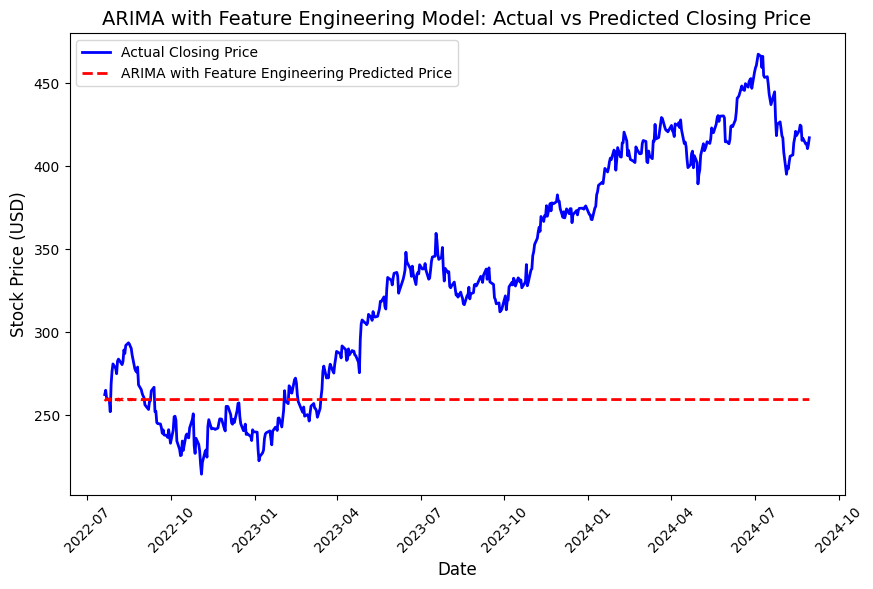

In [188]:
def plot_predictions(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    
    plt.plot(actual.index, actual, color='blue', label='Actual Closing Price', linewidth=2)
    plt.plot(actual.index, predicted, color='red', linestyle='--', label=f'{model_name} Predicted Price', linewidth=2)

    plt.title(f'{model_name} Model: Actual vs Predicted Closing Price', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price (USD)', fontsize=12)
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    
    plt.show()

# Plot ARIMA predictions
plot_predictions(y_test, arima_pred_fe, "ARIMA with Feature Engineering")


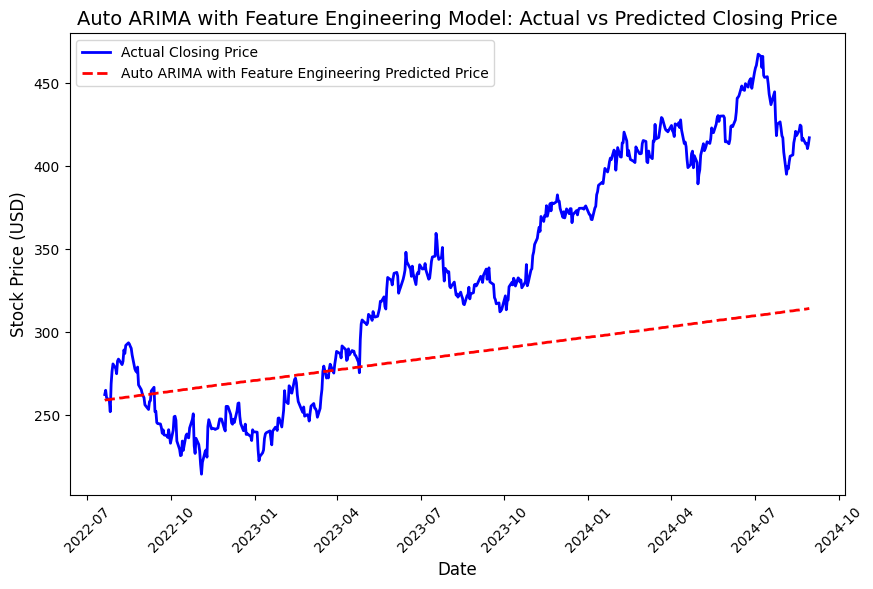

In [189]:
# Plot Auto ARIMA predictions
plot_predictions(y_test, auto_arima_pred_fe, "Auto ARIMA with Feature Engineering")


In [190]:
plt.figure(figsize=(10, 6))

# Actual Closing Price
plt.plot(y_test.index, y_test, color='blue', label='Actual Closing Price', linewidth=2)

# ARIMA Predicted Closing Price
plt.plot(y_test.index, arima_pred_fe, color='red', linestyle='--', label='ARIMA Predicted Price', linewidth=2)

# Auto ARIMA Predicted Closing Price
plt.plot(y_test.index, auto_arima_pred_fe, color='green', linestyle='--', label='Auto ARIMA Predicted Price', linewidth=2)

plt.title('MSFT Final ARIMA vs Auto ARIMA: Actual vs Predicted Closing Price', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
save_plot_with_title(folder)
plt.show()


### Random Forest

In [191]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [192]:
# Baseline model
baseline_model = RandomForestRegressor(random_state=42)
baseline_model.fit(X_train_scaledbase, y_trainbase)

RandomForestRegressor(random_state=42)

In [193]:
# Predict and evaluate
R_baseline_predictions = baseline_model.predict(X_test_scaledbase)

In [194]:
R_baseline_rmse, R_baseline_mae, R_baseline_r2 = evaluate_model(y_testbase, R_baseline_predictions, "Random Forest")

Random Forest Evaluation:
  RMSE: 185.1874
  MAE: 184.4817
  R²: -6.0571



In [195]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_testbase.index, y_testbase, label='True Close Price')
plt.plot(y_testbase.index, R_baseline_predictions, label='Random Forest Predicted Close Price', color='green')
plt.title('MSFT Random Forest Baseline Model - Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
save_plot_with_title(folder)
plt.show()

##### Random Forest Final Prediction

In [196]:
from sklearn.model_selection import GridSearchCV

# Define the model
rf_model = RandomForestRegressor(random_state=42)


In [197]:
# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100,150,200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           verbose=0,
                           scoring='neg_mean_squared_error')

In [198]:

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_squared_error')

In [199]:
# Best parameters and model
best_rf_model = grid_search.best_estimator_
print("Best Random Forest Parameters:", grid_search.best_params_)

Best Random Forest Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [200]:
# Predict and evaluate final model
final_predictions = best_rf_model.predict(X_test)

In [201]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Close Price')
plt.plot(y_test.index, final_predictions, label='Random Forest Predicted Close Price', color='green')
plt.title('MSFT Final Random Forest Model - Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
save_plot_with_title(folder)
plt.show()

In [202]:
# Evaluate Random Forest model predictions
rf_rmse, rf_mae, rf_r2 = evaluate_model(y_test, final_predictions, "Random Forest")

Random Forest Evaluation:
  RMSE: 63.0371
  MAE: 45.6835
  R²: 0.1810



In [203]:
pred_dfr = pd.DataFrame({'Actual': y_test, 'Predicted': final_predictions})
pred_dfr.head()

,Actual,Predicted
Date,,
2022-07-20,262.269989,261.365120
2022-07-21,264.839996,263.919068
2022-07-22,260.359985,255.937320
2022-07-25,258.829987,253.873466
2022-07-26,251.899994,243.677466


In [204]:
import matplotlib.pyplot as plt

feature_importances = best_rf_model.feature_importances_
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('MSFT Random Forest Model Feature Importance')

# Save the figure as a PNG file
save_plot_with_title(folder)

plt.show()


### SVM

In [205]:
from sklearn.svm import SVR

In [206]:
# Baseline model
baseline_svm = SVR(kernel='linear')  # Linear kernel as a starting point
baseline_svm.fit(X_train_scaledbase, y_trainbase)

SVR(kernel='linear')

In [207]:
# Predict and evaluate
baseline_predictionsSVM = baseline_svm.predict(X_test_scaledbase)

In [208]:
# Evaluate SVM model predictions
base_svm_rmse, base_svm_mae, base_svm_r2 = evaluate_model(y_testbase, baseline_predictionsSVM, "SVM")

SVM Evaluation:
  RMSE: 156.4621
  MAE: 155.6057
  R²: -4.0376



In [209]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_testbase.index, y_testbase, label='True Close Price')
plt.plot(y_testbase.index, baseline_predictionsSVM, label='SVM Predicted Close Price', color='orange')
plt.title('MSFT SVM Baseline Model - Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
# Save the figure as a PNG file
save_plot_with_title(folder)
plt.show()

In [210]:
# Define the model
svm_model = SVR()

In [211]:
# Define the grid of hyperparameters to search
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 0.5, 1.0],
}

In [212]:

# Set up GridSearchCV
grid_search_svm = GridSearchCV(estimator=svm_model,
                                param_grid=param_grid,
                                cv=5,  # 5-fold cross-validation
                                n_jobs=-1,  # Use all available cores
                                verbose=1,
                                scoring='neg_mean_squared_error')


In [213]:
# Fit GridSearchCV
grid_search_svm.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.1, 0.5, 1.0],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='neg_mean_squared_error', verbose=1)

In [214]:
# Best parameters and model
best_svm_model = grid_search_svm.best_estimator_
print("Best SVM Parameters:", grid_search_svm.best_params_)

Best SVM Parameters: {'C': 10, 'epsilon': 1.0, 'kernel': 'poly'}


In [215]:
# Predict and evaluate final model
final_predictions_svm = best_svm_model.predict(X_test)

In [216]:
# Evaluate SVM model predictions
svm_rmse, svm_mae, svm_r2 = evaluate_model(y_test, final_predictions_svm, "SVM")

SVM Evaluation:
  RMSE: 4.7004
  MAE: 3.6711
  R²: 0.9954



In [217]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Close Price')
plt.plot(y_test.index, final_predictions_svm, label='SVM Predicted Close Price', color='orange')
plt.title('MSFT SVM Final Model - Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
# Save the figure as a PNG file
save_plot_with_title(folder)
plt.show()

In [218]:
# prediction
# y_pred_1 = model_1.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': final_predictions_svm})
pred_df.head()

,Actual,Predicted
Date,,
2022-07-20,262.269989,263.554864
2022-07-21,264.839996,265.311575
2022-07-22,260.359985,259.047616
2022-07-25,258.829987,259.124940
2022-07-26,251.899994,253.356633


### LSTM

In [219]:
# !pip install scikeras[tensorflow]


In [220]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 

In [221]:
MSFT.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'log Adj Close',
       'SMA_20', 'RoC_10', 'RSI_14', 'Price_Range', 'Returns',
       'Bollinger_Upper', 'Bollinger_Lower', 'EMA_12', 'EMA_26', 'MACD',
       'MACD_Signal'],
      dtype='object')

In [222]:
closedf = MSFT[['Close']]

In [223]:
# Apply MinMaxScaler
scaler= MinMaxScaler(feature_range=(0, 1))

In [224]:
closedf = scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(2665, 1)


In [225]:
# we keep the training set as 80% and 20% testing set
training_size=int(len(closedf)*0.80)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2132, 1)
test_data:  (533, 1)


In [226]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]    
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [227]:
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2101, 30)
y_train:  (2101,)
X_test:  (502, 30)
y_test (502,)


In [228]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (2101, 30, 1)
X_test:  (502, 30, 1)


In [229]:
def Reg():
    model = Sequential()
    
    model.add(LSTM(70, return_sequences=True, input_shape=(30,1)))
    model.add(LSTM(70, return_sequences=True))
    model.add(LSTM(70))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [230]:
model = Reg()
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.0053 - val_loss: 7.4733e-04
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.2137e-04 - val_loss: 6.7111e-04
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.0752e-04 - val_loss: 8.9166e-04
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.2386e-04 - val_loss: 8.6893e-04
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 9.5453e-05 - val_loss: 6.3033e-04
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 9.6592e-05 - val_loss: 9.2994e-04
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0455e-04 - val_loss: 9.1245e-04
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.1660e-04 - val_loss: 7.2606e-04
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.5302e-04 - val_loss: 5.7604e-04
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 8.0916e-05 - val_loss: 5.8045e-04
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1

In [245]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('MSFT LSTM Training and validation loss')
plt.legend(loc=0)
# Save the figure as a PNG file
save_plot_with_title(folder)
plt.show()

In [232]:
y_pred = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [233]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


((2101, 1), (502, 1))

In [234]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [235]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  4.450833336308858
Train data MSE:  19.80991738759824
Train data MAE:  2.683336188031741
-------------------------------------------------------------------------------------
Test data RMSE:  19.771499951301124
Test data MSE:  390.9122103243003
Test data MAE:  16.520265222070705


In [236]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9975858431376466
Test data explained variance regression score: 0.9734886279461556


In [237]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
pred_df.head()

,Actual,Predicted
0,0.522653,0.511437
1,0.520174,0.510057
2,0.510122,0.508614
3,0.503613,0.499774
4,0.514824,0.492591


In [238]:
plt.figure(figsize=(8,8))
plt.ylabel('Close', fontsize=16)
plt.plot(pred_df)
plt.title('MSFT LSTM Actual Value' 'Predictions')
plt.legend(['Actual Value', 'Predictions'])
# Save the figure as a PNG file
save_plot_with_title(folder)
plt.show()

In [239]:
MSFT.reset_index(inplace=True)

In [240]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': MSFT['Date'],
                       'original_close': MSFT['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2665, 1)
Test predicted data:  (2665, 1)


In [241]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [242]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60]


In [243]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [244]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()